In [1]:
import os
import rawpy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import astroalign as aa

In [100]:
path_to_images = "./data/jupiter/"
file_names = list(filter(lambda x: x.endswith(".dng"), os.listdir(path_to_images)))


grayscale_imgs = []
imgs = []
for file in file_names:
    with rawpy.imread(path_to_images + file) as raw:
        raw_image = raw.raw_image.copy()
        # Take a portion of the image to speed up the process
        x1 = 1900
        x2 = 2900
        y1 = 1100
        y2 = 1700
        
        raw_image_np = raw_image[y1:y2, x1:x2]
        # print(raw_image.shape)

        # Convert to 64 bit float
        raw_image_f = raw_image_np.astype(np.float32)
        grayscale_imgs.append(raw_image_f)
        imgs.append(raw.postprocess(output_bps=16).astype(np.float32))
  

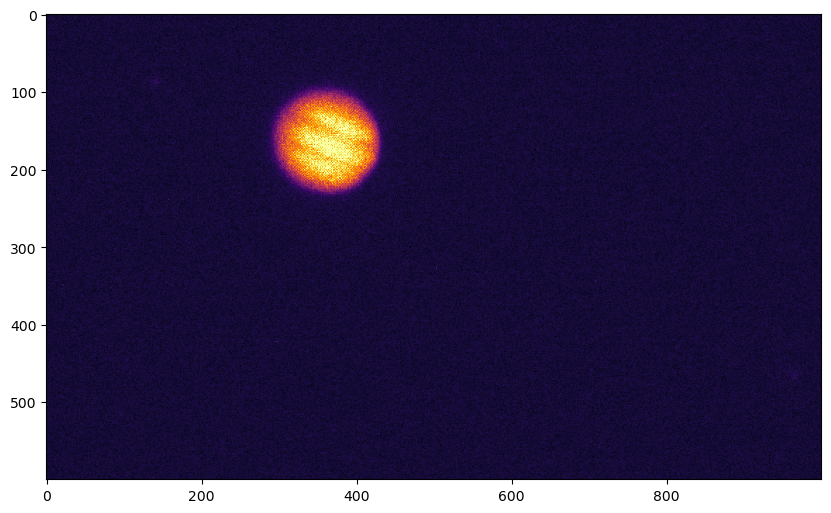

In [103]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.power(grayscale_imgs[50], 1.0), cmap='inferno', vmin=50,vmax=200)
# ax[1].imshow(imgs[50])

Error in image alignment 30
Error in image alignment 54
Error in image alignment 74


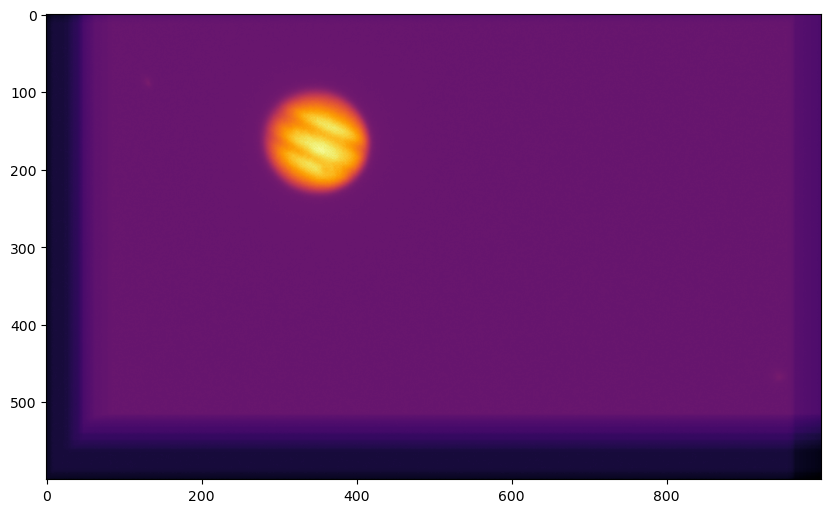

In [113]:
stacked_image = np.copy(grayscale_imgs[0])

err = False;

# Register all images to the first image
for i in range(1, len(grayscale_imgs)):
    # Define the motion model - for ECC, a 2x3 affine transformation matrix is used
    warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Define the number of iterations and the threshold
    number_of_iterations = 2000
    termination_eps = 1e-10
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)

    try:
        (cc, warp_matrix) = cv2.findTransformECC(grayscale_imgs[0], grayscale_imgs[i], warp_matrix, cv2.MOTION_TRANSLATION, criteria)

        aligned_img = cv2.warpAffine(grayscale_imgs[i], warp_matrix,
                                    (grayscale_imgs[0].shape[1], grayscale_imgs[1].shape[0]),
                                    flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        stacked_image += aligned_img
    except:
        print("Error in image alignment", i)
        # Show the image.
        # fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # ax.imshow(np.power(grayscale_imgs[i], 1.0), cmap='inferno', vmin=50,vmax=200)
        err = True

if not err:
    print("All images aligned successfully")

# Normalize the stacked image
stacked_image /= len(grayscale_imgs)

plt.figure(figsize=(10, 10))
plt.imshow(np.power(stacked_image, 1.0), cmap='inferno')    

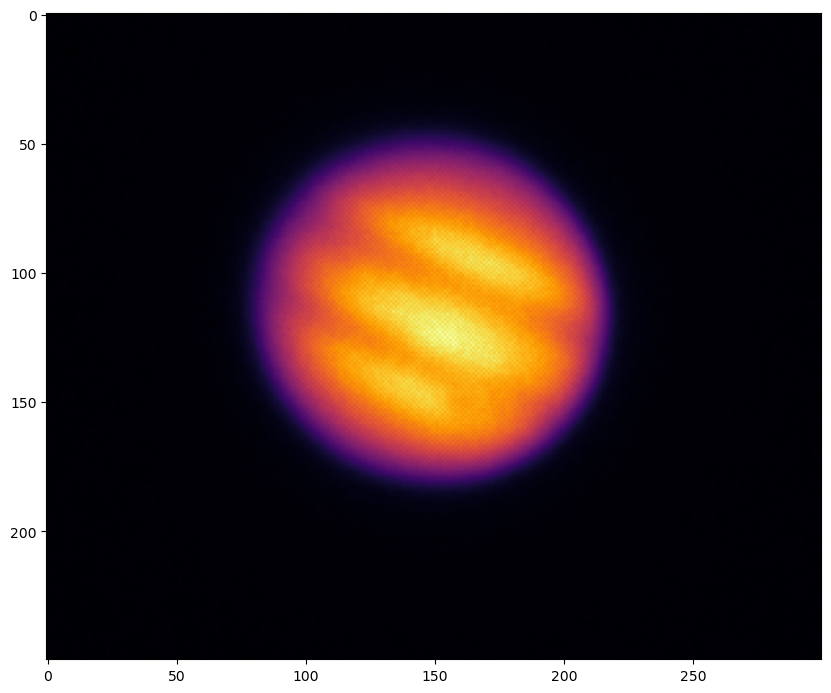

In [114]:
# Zoom in to the planet
x1 = 200
x2 = 500
y1 = 50
y2 = 300

plt.figure(figsize=(10, 10))
plt.imshow(np.power(stacked_image[y1:y2, x1:x2], 1.0), cmap='inferno')

In [195]:
imgs = []

for file in file_names:
    with rawpy.imread(path_to_images + file) as raw:
        rgb = raw.postprocess(gamma=(1,1), no_auto_bright=True, output_bps=16)

        x1 = 1500
        x2 = 2000
        y1 = 2000
        y2 = 2500
        cropped_rgb = rgb[y1:y2, x1:x2]
        normalized_rgb = (cropped_rgb / np.max(cropped_rgb)).astype(np.float32)
        imgs.append(normalized_rgb)

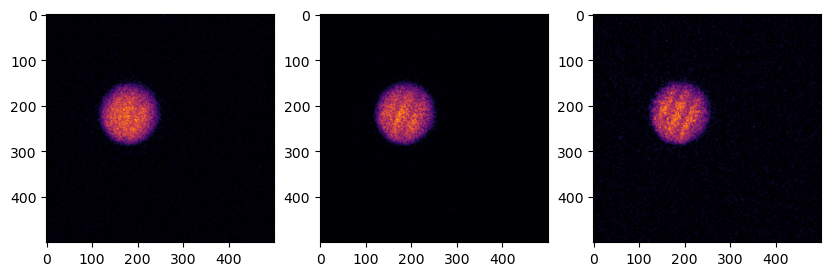

In [206]:
fix, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(imgs[5][:,:,0], cmap='inferno')
ax[1].imshow(imgs[5][:,:,1], cmap='inferno')
ax[2].imshow(imgs[5][:,:,2], cmap='inferno')

In [207]:


# Define the number of iterations and the threshold
number_of_iterations = 10000
termination_eps = 1e-10
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations, termination_eps)

def align(im, target):
    # Define the motion model - for ECC, a 2x3 affine transformation matrix is used
    warp_matrix = np.eye(2, 3, dtype=np.float32)

    (cc, warp_matrix) = cv2.findTransformECC(target, im, warp_matrix, cv2.MOTION_TRANSLATION, criteria)
    return cv2.warpAffine(im, warp_matrix,
                            (target.shape[1], im.shape[0]),
                            flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

Error in image alignment 7
Error in image alignment 15
Error in image alignment 20
Error in image alignment 30
Error in image alignment 31
Error in image alignment 45
Error in image alignment 54
Error in image alignment 74


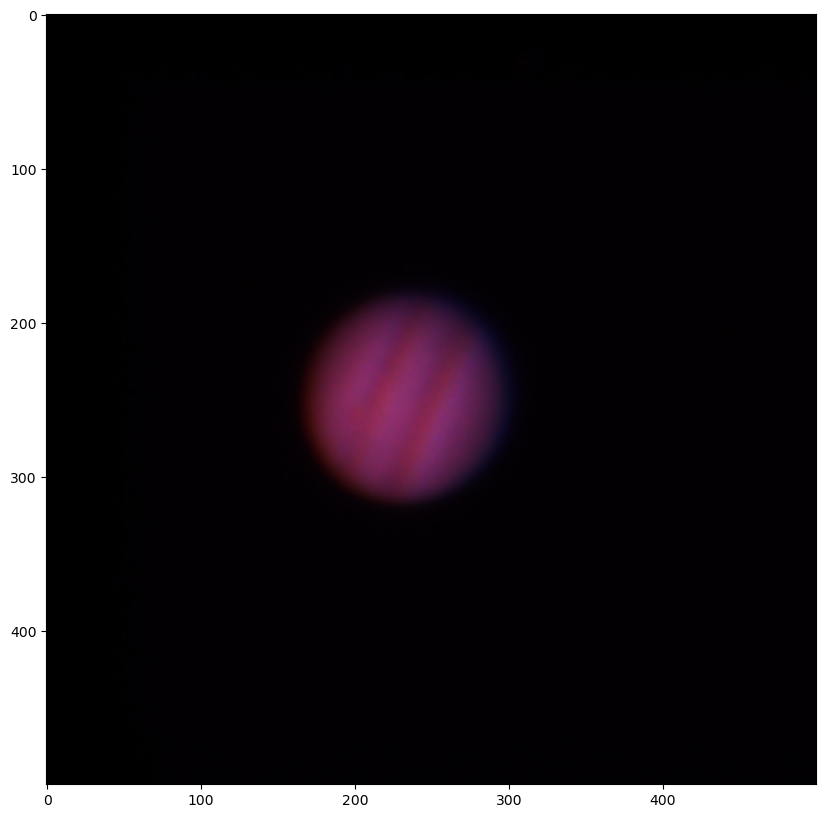

In [208]:
stacked_image = np.copy(imgs[0])

err = False;

# Register all images to the first image
for i in range(1, len(imgs)):
    # Channel-wise
    r = imgs[i][:,:,0]
    g = imgs[i][:,:,1]
    b = imgs[i][:,:,2]

    try:
        r_aligned = align(r, imgs[0][:,:,0])
        g_aligned = align(g, imgs[0][:,:,1])
        b_aligned = align(b, imgs[0][:,:,2])

        stacked_image[:,:,0] += r_aligned
        stacked_image[:,:,1] += g_aligned
        stacked_image[:,:,2] += b_aligned
    except:
        print("Error in image alignment", i)

# Normalize the stacked image
stacked_image /= len(imgs)

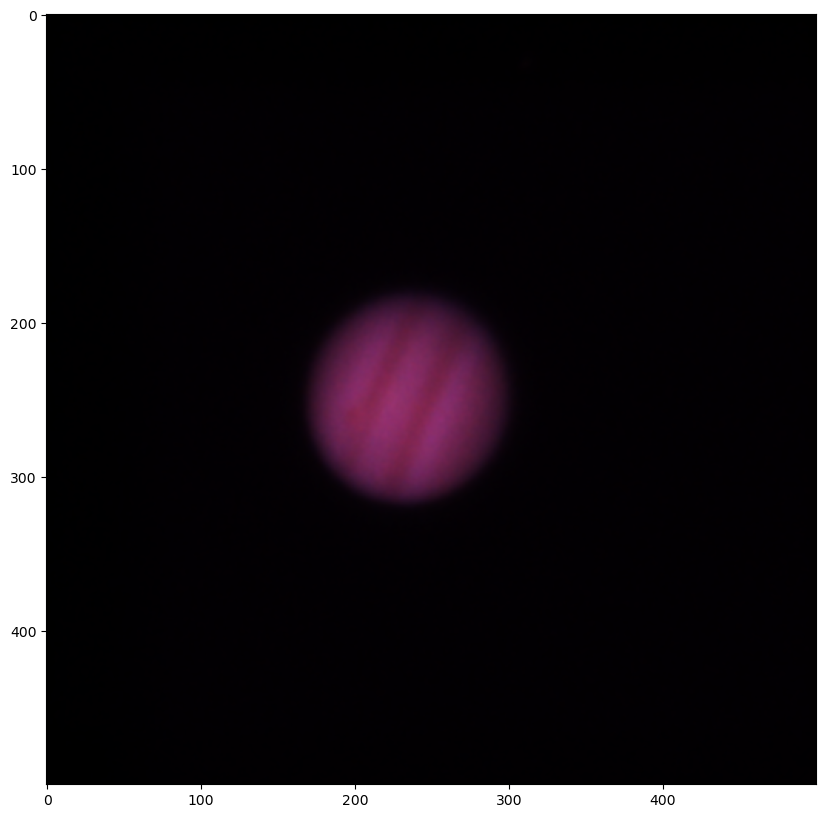

In [209]:
# Try to align channels
r = stacked_image[:,:,0]
g = stacked_image[:,:,1]
b = stacked_image[:,:,2]

r_aligned = align(r, g)
b_aligned = align(b, g)

stacked_image[:,:,0] = r_aligned
stacked_image[:,:,2] = b_aligned

plt.figure(figsize=(10, 10))
plt.imshow(stacked_image)

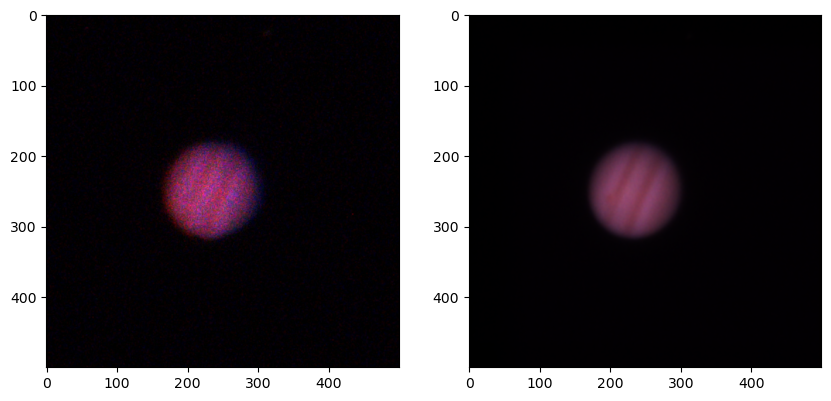

In [210]:
# Color correction
stacked_image_corrected = stacked_image.copy()
stacked_image_corrected[:,:,0] = stacked_image_corrected[:,:,0] * 1.0
stacked_image_corrected[:,:,1] = stacked_image_corrected[:,:,1] * 1.5
stacked_image_corrected[:,:,2] = stacked_image_corrected[:,:,2] * 1.0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(imgs[0])
ax[1].imshow(stacked_image_corrected)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


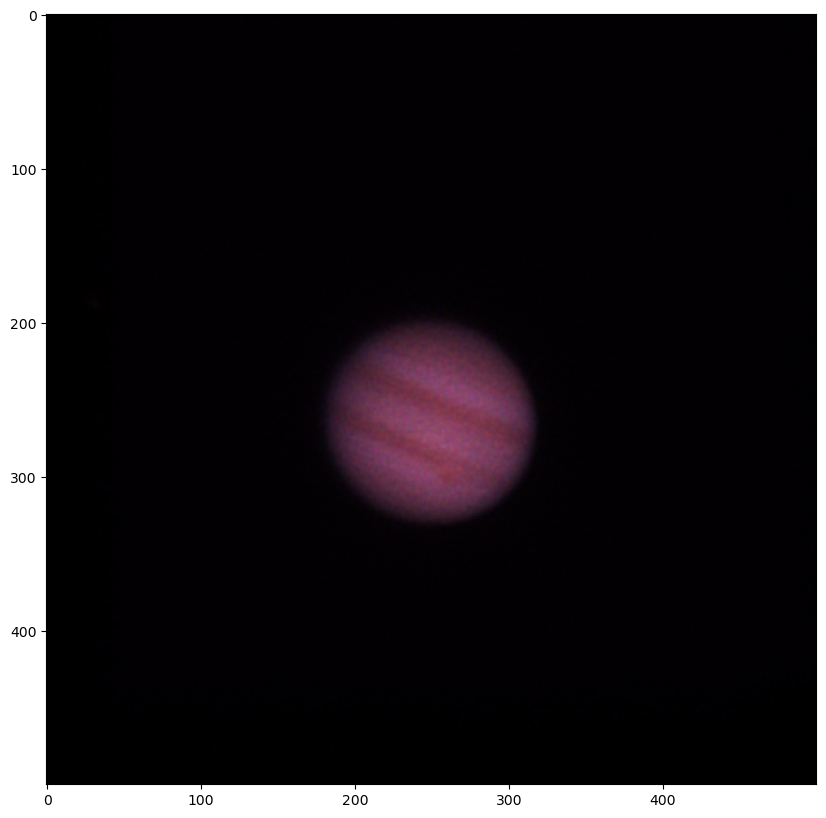

In [211]:
# Image sharpening
sharpening_amount = 2.0
blurred = cv2.GaussianBlur(stacked_image_corrected, ksize=(13, 13), sigmaX=2.0, sigmaY=2.0)
sharpened = (sharpening_amount + 1) * stacked_image_corrected - sharpening_amount * blurred

# Rotate the image & show big
rotated_image = cv2.rotate(sharpened, cv2.ROTATE_90_COUNTERCLOCKWISE)

plt.figure(figsize=(10, 10))
plt.imshow(rotated_image)

/var/folders/kn/9wgdym6s6v3fmrwb6hh6pr480000gn/T/ipykernel_13479/328554745.py:2: RuntimeWarning: invalid value encountered in power
  contrasted_image = np.power(rotated_image, 1.2) * 1.4


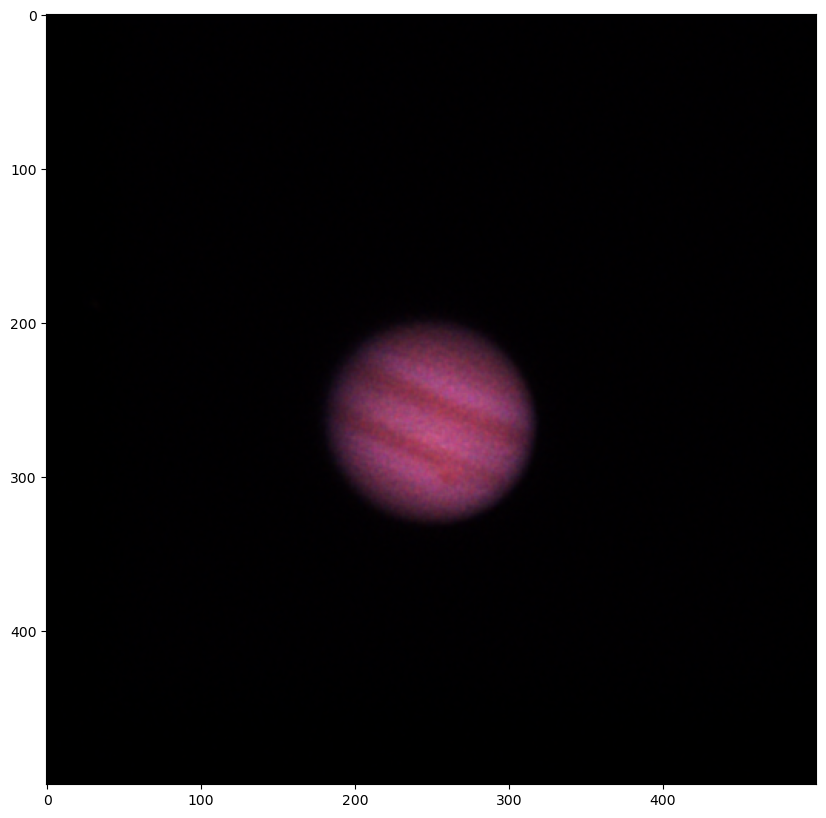

In [213]:
# Increase contrast
contrasted_image = np.power(rotated_image, 1.2) * 1.4

plt.figure(figsize=(10, 10))
plt.imshow(contrasted_image)

In [214]:
# Save the image
plt.imsave("jupiter.png", contrasted_image)